# Dominant colours - Introduction
This is the second part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook builds a dominant colours detection system based on K-Means clustering algorithm to find a list of 10 dominant colours and their distribution for each picture in the dataset.

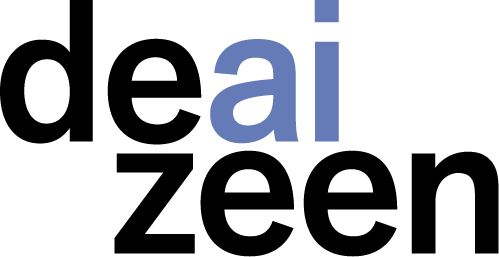

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import timeit
import tqdm.notebook as tq
import sys

# Colour detection

## Images DataFrame

In [7]:
df = pd.read_csv('files/images.csv', index_col=0)
df

,id,url,path
0,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
1,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
2,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
3,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
4,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
...,...,...,...
47172,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg
47173,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg
47174,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg
47175,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg


## Helper functions

In [13]:
def displayImage(img):
  
  if isinstance(img, str):
    # read image file & convert to rgb
    image = cv2.imread(img)
    image = cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
        ) 
  else:
    image = img
  
  # switch off axis
  plt.axis('off')

  # display image
  plt.imshow(image)

In [14]:
def preprocessImage(imagepath, dsize=(16,16)):

  # load image & convert to rgb
  image = cv2.imread(imagepath)
  image = cv2.cvtColor(
      image,
      cv2.COLOR_BGR2RGB
      )

  # scale down the image
  image = cv2.resize(
      image,
      dsize=dsize,
      interpolation=cv2.INTER_CUBIC
      )

  return image

In [27]:
def clusterColours(image, clusters=10):

  # reshape the image to a list of pixels
  image = image.reshape((image.shape[0] * image.shape[1],3))

  # cluster the color in the image
  clt = KMeans(n_clusters=clusters)
  clt.fit(image)

  return clt

In [16]:
def centroidHistogram(clt):

    # number of clusters
    numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
    # histrogram of the number of pixels
    (hist,_) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histrogram, such that it sums to one'
    hist = hist.astype('float')
    hist /= hist.sum()
    
    return hist

In [66]:
def colourBar(hist, clt):
    # init the rectable size
    bar = np.zeros((50,300,3), dtype='uint8')
    startX = 0
    
    # loop over the percentage of each color cluster and the color of each cluster
    for (percent, color) in zip(hist, clt.cluster_centers_):
        endX = startX + (percent*300)
        cv2.rectangle(bar,(int(startX),0),(int(endX),50),
                          color.astype("uint8").tolist(),-1)
        startX = endX
    
    return bar

## Test

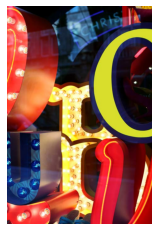

In [63]:
path = df['path'][np.random.randint(0, df.shape[0])]
displayImage(path)

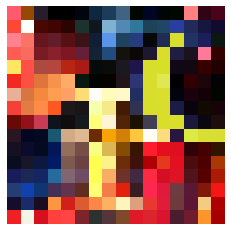

In [67]:
image = preprocessImage(path)
displayImage(image)

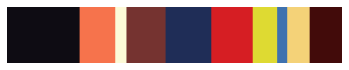

In [68]:
image = preprocessImage(path)
clt = clusterColours(image)
histogram = centroidHistogram(clt)
bar = colourBar(histogram, clt)

plt.figure()
plt.axis('off')
plt.imshow(bar)
plt.show()

## Scan dataset

In [70]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few hours to complete...\n')

paths = df['path']
colours = []
distributions = []

for path in tq.tqdm(paths):
  
  try:
    image = preprocessImage(path)
    clt = clusterColours(image)
    dist = centroidHistogram(clt)
    
    colours.append(clt.cluster_centers_)
    distributions.append(dist)

  except:
    colours.append(np.nan)
    distributions.append(np.nan)

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few hours to complete...




Runtime: 18268 seconds.


## Update the DataFrame

In [71]:
df['colours'] = colours
df['distribution'] = distributions
df

,id,url,path,colours,distribution
0,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[[233.2, 172.3, 84.0], [60.5, 73.7857142857142...","[0.0390625, 0.0546875, 0.17578125, 0.14453125,..."
1,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[[36.272727272727266, 55.0, 84.18181818181819]...","[0.04296875, 0.18359375, 0.125, 0.10546875, 0...."
2,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[[109.44444444444444, 76.5, 41.111111111111114...","[0.0703125, 0.04296875, 0.12109375, 0.18359375..."
3,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[[23.441176470588232, 10.411764705882355, 6.76...","[0.1328125, 0.10546875, 0.15625, 0.05859375, 0..."
4,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[[244.44444444444446, 199.55555555555554, 137....","[0.03515625, 0.10546875, 0.09765625, 0.0625, 0..."
...,...,...,...,...,...
47172,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[[33.75, 24.66666666666667, 10.666666666666664...","[0.046875, 0.109375, 0.0390625, 0.1640625, 0.0..."
47173,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,"[[121.61904761904762, 99.0952380952381, 62.238...","[0.08203125, 0.3359375, 0.06640625, 0.07421875..."
47174,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,"[[51.434782608695656, 41.608695652173914, 26.3...","[0.08984375, 0.10546875, 0.015625, 0.0703125, ..."
47175,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,"[[124.81395348837209, 107.02325581395348, 76.9...","[0.16796875, 0.11328125, 0.01953125, 0.1679687..."


## Export the DataFrame

In [76]:
# increase the maximum depth of the Python interpreter to avoid an overflow error
sys.setrecursionlimit(10000)

# export
df.to_pickle('files/images_colours.pkl')